In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
s = 'https://archive.ics.uci.edu/ml/'\
    'machine-learning-databases/iris/iris.data'
print("From url:", s)
df = pd.read_csv(s, header=None, encoding='utf-8')
df.tail()


From url: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


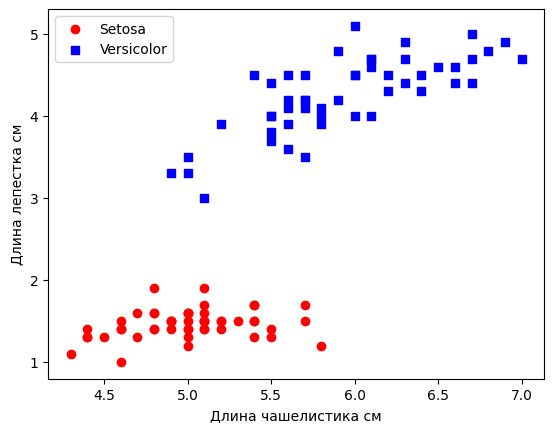

In [4]:
y = df.iloc[0:100, 4].values
y = np.where(y == "Iris-setosa", 0, 1)
X = df.iloc[0:100, [0, 2]].values
plt.scatter(X[:50, 0], X[:50, 1], c='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], c='blue', marker='s', label='Versicolor')
plt.xlabel("Длина чашелистика см")
plt.ylabel("Длина лепестка см")
plt.legend(loc='upper left')
plt.show()

In [5]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data[:, [2, 3]]
y = iris.target
print(np.unique(y))

[0 1 2]


In [6]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(X[y == cl, 0], 
                    X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolors='black')
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='none', edgecolor='black', alpha=1.0, linewidths=1, marker='o', s=100, label='Test set')


In [7]:
class AdalineGD:

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

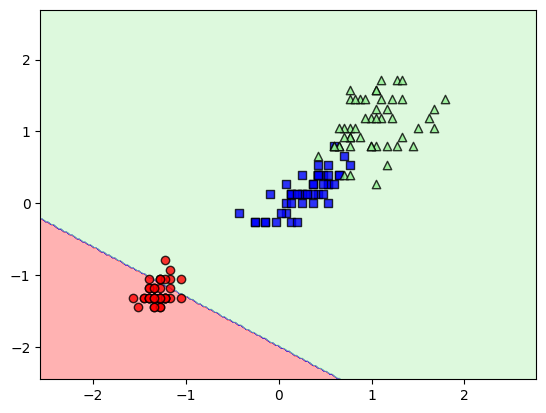

In [8]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
ada_gd = AdalineGD(0.5, 20)
ada_gd.fit(X_std, y)
plot_decision_regions(X_std, y, ada_gd)

# Классификаторы из scikit-learn

In [9]:
class LogisticRegressionGD:

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = float(0.)
        self.losses_ = []

        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = y - output
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (-y.dot(np.log(output)) - (1 - y).dot(np.log(1 - output))) / X.shape[0]
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

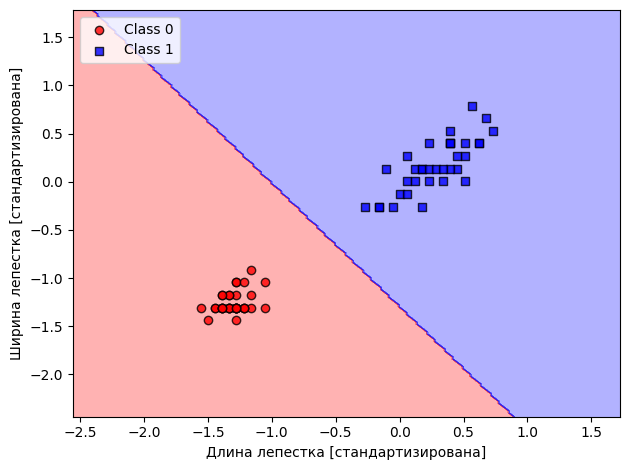

In [11]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X_train_01_subset, y_train_01_subset, lrgd)
plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

c:\Users\Глеб\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


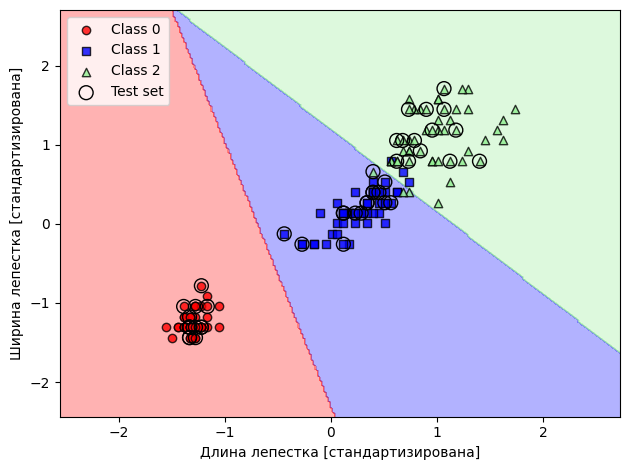

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)
plot_decision_regions(np.vstack((X_train_std, X_test_std)), np.hstack((y_train, y_test)), lr, range(105, 150))

plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

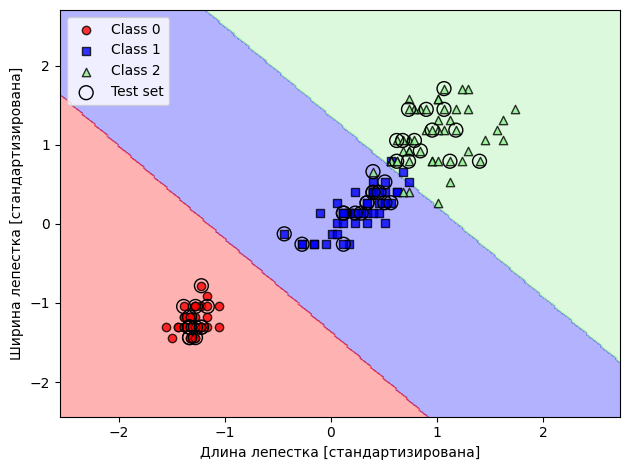

In [13]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined_std, y_combined, svm, range(105, 150))

plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

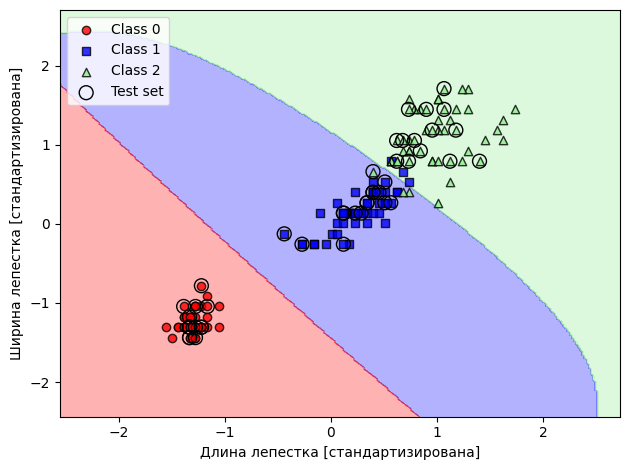

In [14]:
svmk = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svmk.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svmk, test_idx=range(105, 150))

plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

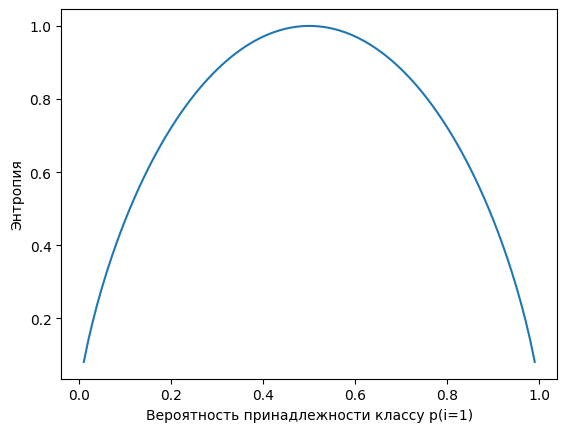

In [15]:
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
plt.ylabel('Энтропия')
plt.xlabel('Вероятность принадлежности классу p(i=1)')
plt.plot(x, ent)
plt.show()

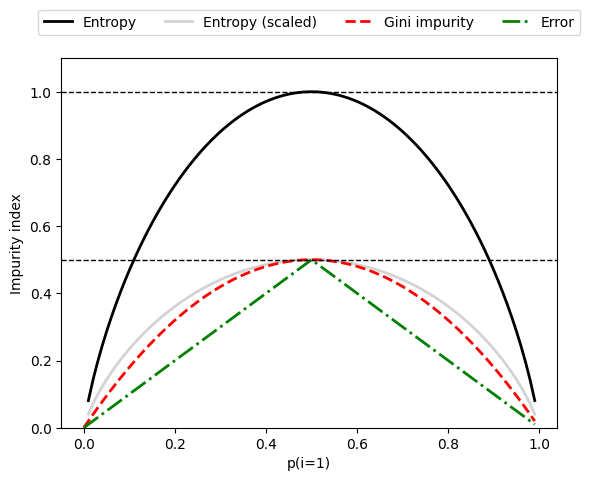

In [16]:
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))

def error(p):
    return 1 - np.max([p, 1 - p])

sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (scaled)',
                           'Gini impurity',
                           'Error'], 
                           ['-', '-', '--', '-.'],
                           ['black', 'lightgrey', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity index')
plt.show()

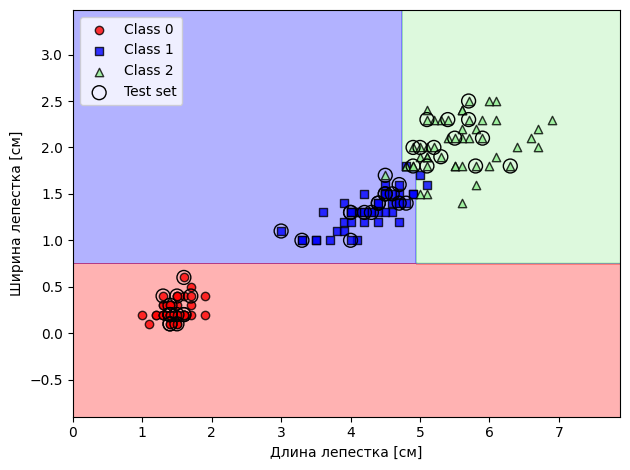

In [17]:
from sklearn.tree import DecisionTreeClassifier


tree_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree_model.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
plot_decision_regions(X_combined, y_combined, classifier=tree_model, test_idx=range(105, 150))

plt.xlabel("Длина лепестка [см]")
plt.ylabel("Ширина лепестка [см]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

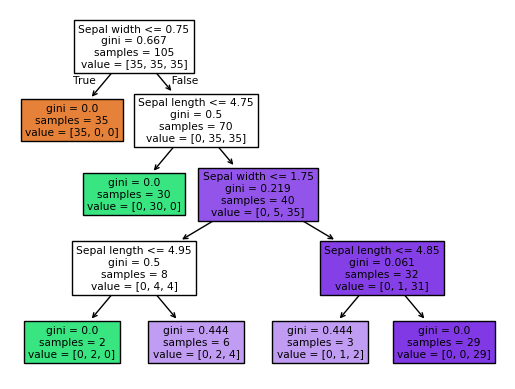

In [18]:
from sklearn import tree

feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']
tree.plot_tree(tree_model, feature_names=feature_names, filled=True)
plt.show()

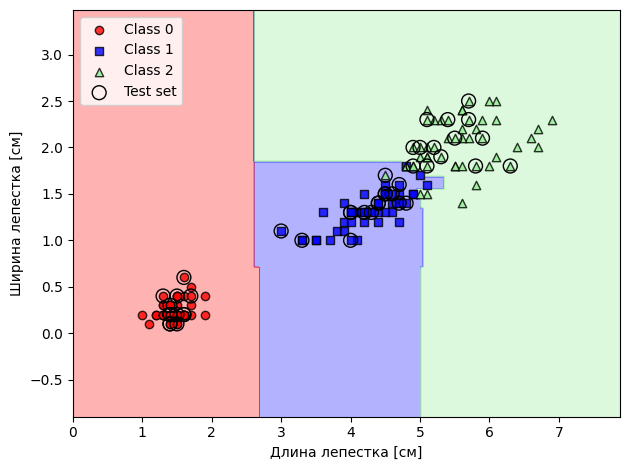

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=25,
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined,
                      classifier=forest, test_idx=range(105, 150))
plt.xlabel("Длина лепестка [см]")
plt.ylabel("Ширина лепестка [см]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

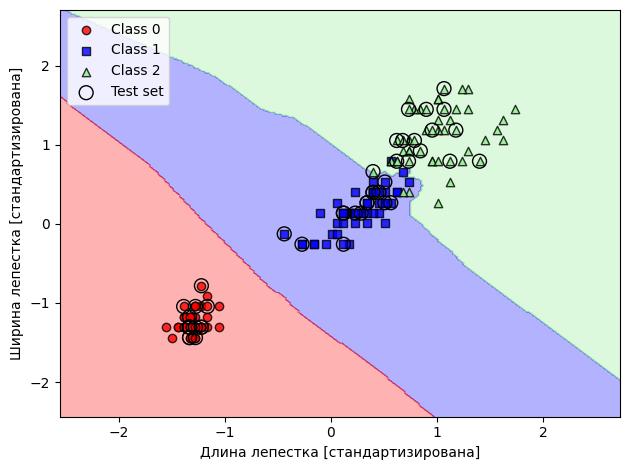

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2,
                           metric='minkowski')
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, test_idx=range(105, 150))
plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Предобработка данных для качественных обучающих наборов
## Выявление пустых данных

In [21]:
from io import StringIO
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))

In [22]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

## Удаление пустых значений

In [23]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [24]:
df.dropna(subset=['C']) # Удаляет строки, в которых NaN содержится только в заданных столбцах

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


In [25]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


## Работа с категориальными признаками

In [27]:
df1 = pd.DataFrame([
            ['green', 'M', 10.1, 'class2'],
            ['red', 'L', 13.5, 'class1'],
            ['blue', 'XL', 15.3, 'class2']])
df1.columns = ['color', 'size', 'price', 'classlabel']
df1

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [28]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}
df1['size'] = df1['size'].map(size_mapping)
df1

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [ ]:
class_mapping = {label: idx for idx, label in 
                enumerate(np.unique(df1['classlabel']))}
df1['classlabel'] = df1['classlabel'].map(class_mapping)
df1 # Ручной LabelEncoder()

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df1['classlabel'].values)
y

array([1, 0, 1])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
X = df1[['color', 'size', 'price']].values
ohe = OneHotEncoder() # Если передать в аргументы drop='first', category='auto', то ничего не потеряем
ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [ ]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1, 2])
])
ct.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [45]:
pd.get_dummies(df1[['color', 'size', 'price']])

,size,price,color_blue,color_green,color_red
0,1,10.1,False,True,False
1,2,13.5,False,False,True
2,3,15.3,True,False,False


## Раздзеление набора данных

In [52]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/'
                      'wine/wine.data', header=None)

In [54]:
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [56]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y) # Для огромных наборов данных уместно соотношение 90:10 (>= 100тыс. записей)

### Многие алгоритмы хотят масштабирования, не хотят только случайные леса
Есть *нормализация* - числа в диапазон [0, 1].  
Есть *стандартизация* - центрируем столбцы данных по среднему значению 0 со стандартным отклонением 1.

Используются  
*MinMaxScaler()* - для нормализации  
*StandartScaler()* - стандартизации  
*RobustScaler()* - поможет при малом наборе данных и сильных выбросах, если алгоритм склонен к переобучению

In [57]:
from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()
X_train_std = ssc.fit_transform(X_train)
X_test_std = ssc.fit_transform(X_test)

### Способы борьбы с переобучением
- собрать больше обучающих данных (редко и почти анрил)
- регуляризация
- взять более простую модель
- уменьшть размерность данных

In [60]:
lr = LogisticRegression(penalty='l1',
                        C=1.0,
                        solver='liblinear',
                        multi_class='ovr')
lr.fit(X_train_std, y_train)
print(f'Точность при обучении: {lr.score(X_train_std, y_train)}')
print(f'Точность при тестировании: {lr.score(X_test_std, y_test)}')

Точность при обучении: 1.0
Точность при тестировании: 1.0


c:\Users\Глеб\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [62]:
lr.coef_

array([[ 1.24591594,  0.18062024,  0.74468159, -1.16242078,  0.        ,
         0.        ,  1.16550934,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55158987,  2.50973979],
       [-1.53704423, -0.387247  , -0.99542609,  0.36495873, -0.05935784,
         0.        ,  0.66795419,  0.        ,  0.        , -1.93388882,
         1.23408773,  0.        , -2.23212111],
       [ 0.13583998,  0.16846806,  0.35725387,  0.        ,  0.        ,
         0.        , -2.43816448,  0.        ,  0.        ,  1.56353957,
        -0.8186881 , -0.49246611,  0.        ]])